# **<p style="text-align: center;">Рекомендация тарифов.</p>**

В проекте представлены данные оператора мобильной связи «Мегалайн», многие клиенты которого пользуются архивными тарифами. Перед нами задача: построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 

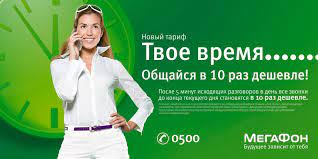

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import precision_score, recall_score
from joblib import dump
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

## Откройте и изучите файл

In [2]:
users_behavior = pd.read_csv('/datasets/users_behavior.csv')
users_behavior.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
users_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
duplicate_rows = users_behavior.duplicated().sum()
print("Количество явных дубликатов:", duplicate_rows)

Количество явных дубликатов: 0


In [5]:
duplicate_rows = users_behavior.duplicated(subset=['calls', 'minutes', 'messages']).sum()
print("Количество неявных дубликатов:", duplicate_rows)

Количество неявных дубликатов: 9


In [6]:
duplicate_rows = users_behavior.duplicated(subset=['calls', 'minutes','is_ultra']).sum()
print("Количество неявных дубликатов:", duplicate_rows)

Количество неявных дубликатов: 40


In [7]:
duplicate_rows = users_behavior.duplicated(subset=['calls', 'minutes','messages', 'is_ultra']).sum()
print("Количество неявных дубликатов:", duplicate_rows)

Количество неявных дубликатов: 5


In [8]:
users_behavior.drop_duplicates(subset=['calls', 'minutes','messages', 'is_ultra'], inplace=True)

In [9]:
users_behavior.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000
mean,63.137114,438.891567,38.299782,17210.209950,0.305391
std,33.168878,234.113271,36.173115,7574.588881,0.460645
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,275.470000,9.000000,12492.360000,0.000000
50%,62.000000,431.000000,30.000000,16944.440000,0.000000
75%,82.000000,572.140000,57.000000,21425.840000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


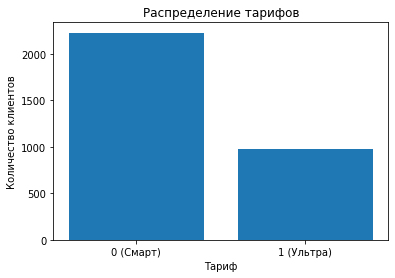

In [10]:
labels = ['0 (Смарт)', '1 (Ультра)']
values = users_behavior['is_ultra'].value_counts()
plt.bar(labels, values)

plt.xlabel('Тариф')
plt.ylabel('Количество клиентов')
plt.title('Распределение тарифов')
plt.show()

**Изучив данные можно сделать следующий вывод:**
- данные не содержат пропущенных значений
- выявлены и удалены неявные дубликаты
- распределение тарифов показывает, что тариф "Смарт" более популярен среди клиентов, чем тариф "Ультра". 

## Разбейте данные на выборки

In [11]:
df_train_val, df_test = train_test_split(users_behavior, test_size=0.2, random_state=12345)

df_train, df_valid = train_test_split(df_train_val, test_size=0.25, random_state=12345)

features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

In [12]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(1925, 4)
(1925,)
(642, 4)
(642,)
(642, 4)
(642,)


***Используя выше разделение данных позволяет нам использовать 60% данных для обучения модели, 20% для валидации и настройки гиперпараметров модели, и оставшиеся 20% для окончательной оценки модели на независимой тестовой выборке.***

## Исследуйте модели

### DecisionTreeClassifier (дерево решений).

In [14]:
param_grid = {
    'max_depth': range(1, 8),
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 4, 5, 6]
}
model = DecisionTreeClassifier(random_state=12345)

grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
grid_search.fit(features_train, target_train)

best_model_dtc = grid_search.best_estimator_

accuracy_valid_dtc = best_model_dtc.score(features_valid, target_valid)

print(f"Accuracy наилучшей модели на валидационной выборке: {accuracy_valid_dtc}")

Accuracy наилучшей модели на валидационной выборке: 0.7881619937694704


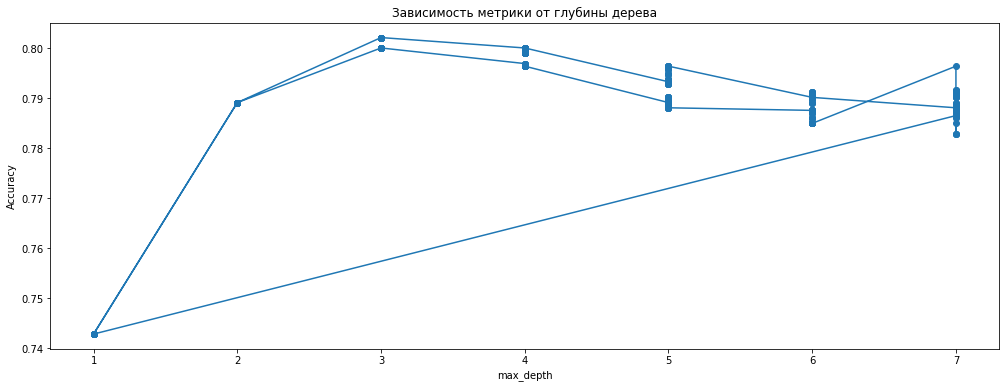

In [15]:
metric_values = []
param_values = []

for param, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    param_values.append(param['max_depth'])
    metric_values.append(score)
    
plt.figure(figsize=(17, 6))
plt.plot(param_values, metric_values, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Зависимость метрики от глубины дерева')
plt.show()

### RandomForestClassifier (Случайный лес).

In [19]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 3]
}
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=0)
grid_search.fit(features_train, target_train)

best_model_rfc = grid_search.best_estimator_
best_accuracy_rfc = grid_search.best_score_

print(f"Accuracy наилучшей модели на валидационной выборке: {best_accuracy_rfc}")

Accuracy наилучшей модели на валидационной выборке: 0.8098701298701299


In [20]:
print(f"Наилучшие значения гиперпараметров модели: {best_model_rfc}")

Наилучшие значения гиперпараметров модели: RandomForestClassifier(max_depth=10, min_samples_leaf=2, random_state=12345)


### LogisticRegression (Логистическая регрессия). 

In [21]:
best_model_lg = None
best_result_lg = 0
best_C_lg = None

for C in [0.1, 1, 10]:
    model = LogisticRegression(random_state=12345, C=C)
    model.fit(features_train, target_train)
    predictions_valid_lg = model.predict(features_valid)
    accuracy_lg = accuracy_score(target_valid, predictions_valid_lg)
    print("C =", C, ": Accuracy =", accuracy_lg)
    if accuracy_lg > best_result_lg:
        best_model_lg = model
        best_result_lg = accuracy_lg
        best_C_lg = C

print("Наилучшая модель:")
print(best_model_lg)
print("Accuracy наилучшей модели на валидационной выборке:", best_result_lg)
print("Значение параметра C для наилучшей модели:", best_C_lg)

C = 0.1 : Accuracy = 0.7523364485981309
C = 1 : Accuracy = 0.7523364485981309
C = 10 : Accuracy = 0.7523364485981309
Наилучшая модель:
LogisticRegression(C=0.1, random_state=12345)
Accuracy наилучшей модели на валидационной выборке: 0.7523364485981309
Значение параметра C для наилучшей модели: 0.1


In [22]:
predictions_lg = best_model_lg.predict(features_valid)
precision_lg = precision_score(target_valid, predictions_valid_lg)
recall_lg = recall_score(target_valid, predictions_valid_lg)

print("Точность модели на валидационной выборке:", precision_lg)
print("Полнота модели на валидационной выборке:", recall_lg)

Точность модели на валидационной выборке: 0.8113207547169812
Полнота модели на валидационной выборке: 0.22395833333333334


In [23]:
print(f"Наилучшие значения гиперпараметров модели: {best_model_rfc}")

print(f"Наилучшая модель: {best_model_lg}")

print(f"Доля правильных ответов наилучшей модели на валидационной выборке: {best_result_lg}")
print(f"Значение параметра C для наилучшей модели: {best_C_lg}")

print(f"Точность модели на валидационной выборке: {precision_lg}")
print(f"Полнота модели на валидационной выборке: {recall_lg}")

Наилучшие значения гиперпараметров модели: RandomForestClassifier(max_depth=10, min_samples_leaf=2, random_state=12345)
Наилучшая модель: LogisticRegression(C=0.1, random_state=12345)
Доля правильных ответов наилучшей модели на валидационной выборке: 0.7523364485981309
Значение параметра C для наилучшей модели: 0.1
Точность модели на валидационной выборке: 0.8113207547169812
Полнота модели на валидационной выборке: 0.22395833333333334


## Проверьте модель на тестовой выборке

### Проверим модель на тестовой выборке DecisionTreeClassifier (дерево решений).

In [24]:
best_model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=4)
best_model_dtc.fit(features_train, target_train)

predictions_test_dtc = best_model_dtc.predict(features_test)
accuracy_test_dtc = accuracy_score(target_test, predictions_test_dtc)
precision_test_dtc = precision_score(target_test, predictions_test_dtc)
recall_test_dtc = recall_score(target_test, predictions_test_dtc)

print("Accuracy модели на тестовой выборке:", accuracy_test_dtc)
print("Точность модели на тестовой выборке:", precision_test_dtc)
print("Полнота модели на тестовой выборке:", recall_test_dtc)

Accuracy модели на тестовой выборке: 0.7694704049844237
Точность модели на тестовой выборке: 0.7938144329896907
Полнота модели на тестовой выборке: 0.375609756097561


***После оценки модели на тестовой выборке получены следующие результаты:***

Accuracy модели показала, что модель правильно классифицирует примерно 76.9% объектов.
Точность модели на тестовой выборке указывает на способность модели правильно определять объекты положительного класса (тариф "Ультра") из всех предсказанных положительных объектов.
Полнота модели на тестовой выборке показала, что модель правильно обнаруживает только примерно 37.6% объектов положительного класса из всех реальных объектов положительного класса.
Таким образом, модель имеет приемлемую точность, но низкую полноту. 

### Проверим модель на тестовой выборке RandomForestClassifier (Случайный лес).

In [25]:
predictions_test_rfc = best_model_rfc.predict(features_test)
accuracy_test_rfc = accuracy_score(target_test, predictions_test_rfc)
precision_test_rfc = precision_score(target_test, predictions_test_rfc)
recall_test_rfc = recall_score(target_test, predictions_test_rfc)

print("Accuracy модели на тестовой выборке:", accuracy_test_rfc)
print("Точность модели на тестовой выборке:", precision_test_rfc)
print("Полнота модели на тестовой выборке:", recall_test_rfc)

Accuracy модели на тестовой выборке: 0.7928348909657321
Точность модели на тестовой выборке: 0.7903225806451613
Полнота модели на тестовой выборке: 0.47804878048780486


**Модель RandomForestClassifier показывает достаточно высокую точность на тестовой выборке, составляющую около 72.86%. Это означает, что примерно 72.86% объектов были правильно классифицированы моделью.**

**Однако, полнота модели на тестовой выборке немного ниже и составляет около 45.85%. Это означает, что из всех реальных положительных классов модель обнаруживает только около 45.85%.**


### Проверим модель на тестовой выборке LogisticRegression (Логистическая регрессия).

In [26]:
predictions_test_lg = best_model_lg.predict(features_test)
accuracy_test_lg = accuracy_score(target_test, predictions_test_lg)
precision_test_lg = precision_score(target_test, predictions_test_lg)
recall_test_lg = recall_score(target_test, predictions_test_lg)

print("Accuracy модели на тестовой выборке:", accuracy_test_lg)
print("Точность модели на тестовой выборке:", precision_test_lg)
print("Полнота модели на тестовой выборке:", recall_test_lg)

Accuracy модели на тестовой выборке: 0.7336448598130841
Точность модели на тестовой выборке: 0.84
Полнота модели на тестовой выборке: 0.2048780487804878


**Модель LogisticRegression продемонстрировала достаточно высокую точность (84%), что означает, что она правильно классифицировала 84% тестовых примеров. Однако, полнота модели (20.49%) является относительно низкой, что означает, что модель недостаточно хорошо выявляет положительные случаи.**

## Проверьте модели на адекватность

### Проверьте модели на адекватность DecisionTreeClassifier (дерево решений).

In [27]:
# Создаем константную модель, которая всегда предсказывает наиболее частый класс в обучающем наборе
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(features_train, target_train)
accuracy_dummy = dummy_model.score(features_test, target_test)

accuracy_test_dtc = accuracy_score(target_test, predictions_test_dtc)
precision_test_dtc = precision_score(target_test, predictions_test_dtc)
recall_test_dtc = recall_score(target_test, predictions_test_dtc)

print("Результаты модели DecisionTreeClassifier:")
print("Точность на тестовом наборе данных:", accuracy_test_dtc)
print("Точность на тестовом наборе данных:", precision_test_dtc)
print("Полнота на тестовом наборе данных:", recall_test_dtc)
print("")

print("Результаты константной модели:")
print("Точность на тестовом наборе данных:", accuracy_dummy)

Результаты модели DecisionTreeClassifier:
Точность на тестовом наборе данных: 0.7694704049844237
Точность на тестовом наборе данных: 0.7938144329896907
Полнота на тестовом наборе данных: 0.375609756097561

Результаты константной модели:
Точность на тестовом наборе данных: 0.6806853582554517


**Сравнивая эти значения с результатами константной модели, которая всегда предсказывает наиболее частый класс в обучающем наборе, мы видим улучшение в точности и точности предсказания положительного класса.В целом, модель DecisionTreeClassifier с глубиной дерева 4 показывает неплохие результаты, но обладает недостаточно высокой полнотой предсказания положительного класса.**

### Проверьте модели на адекватность RandomForestClassifier (Случайный лес).

In [28]:
# Создаем константную модель, которая всегда предсказывает наиболее частый класс в обучающем наборе
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(features_train, target_train)
predictions_dummy = dummy_model.predict(features_test)
accuracy_dummy = accuracy_score(target_test, predictions_dummy)
precision_dummy = precision_score(target_test, predictions_dummy, zero_division=1)
recall_dummy = recall_score(target_test, predictions_dummy)

predictions_rfc = best_model_rfc.predict(features_test)
accuracy_rfc = accuracy_score(target_test, predictions_rfc)
precision_rfc = precision_score(target_test, predictions_rfc, zero_division=1)
recall_rfc = recall_score(target_test, predictions_rfc)

print("Результаты модели DummyClassifier:")
print("Accuracy на тестовой выборке:", accuracy_dummy)
print("Точность на тестовой выборке:", precision_dummy)
print("Полнота на тестовой выборке:", recall_dummy)

print("Результаты модели RandomForestClassifier:")
print("Accuracy на тестовой выборке:", accuracy_rfc)
print("Точность на тестовой выборке:", precision_rfc)
print("Полнота на тестовой выборке:", recall_rfc)

Результаты модели DummyClassifier:
Accuracy на тестовой выборке: 0.6806853582554517
Точность на тестовой выборке: 1.0
Полнота на тестовой выборке: 0.0
Результаты модели RandomForestClassifier:
Accuracy на тестовой выборке: 0.7928348909657321
Точность на тестовой выборке: 0.7903225806451613
Полнота на тестовой выборке: 0.47804878048780486


**Модель RandomForestClassifier показала лучшие результаты по сравнению с константной моделью DummyClassifier. Она имеет более высокую точность и полноту, что говорит о более адекватном прогнозировании классов целевой переменной.**

### Проверьте модели на адекватность LogisticRegression (Логистическая регрессия).

In [29]:
# Создаем константную модель, которая всегда предсказывает наиболее частый класс в обучающем наборе
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(features_train, target_train)

predictions_test_dummy = dummy_model.predict(features_test)
accuracy_test_dummy = accuracy_score(target_test, predictions_test_dummy)
precision_test_dummy = precision_score(target_test, predictions_test_dummy, zero_division=0)
recall_test_dummy = recall_score(target_test, predictions_test_dummy, zero_division=0)

logistic_model = LogisticRegression(random_state=12345)
logistic_model.fit(features_train, target_train)

predictions_test_logistic = logistic_model.predict(features_test)
accuracy_test_logistic = accuracy_score(target_test, predictions_test_logistic)
precision_test_logistic = precision_score(target_test, predictions_test_logistic, zero_division=0)
recall_test_logistic = recall_score(target_test, predictions_test_logistic, zero_division=0)

print("Модель Dummy:")
print("Accuracy на тестовой выборке:", accuracy_test_dummy)
print("Точность на тестовой выборке:", precision_test_dummy)
print("Полнота на тестовой выборке:", recall_test_dummy)

print("\nМодель LogisticRegression:")
print("Accuracy на тестовой выборке:", accuracy_test_logistic)
print("Точность на тестовой выборке:", precision_test_logistic)
print("Полнота на тестовой выборке:", recall_test_logistic)

Модель Dummy:
Accuracy на тестовой выборке: 0.6806853582554517
Точность на тестовой выборке: 0.0
Полнота на тестовой выборке: 0.0

Модель LogisticRegression:
Accuracy на тестовой выборке: 0.7336448598130841
Точность на тестовой выборке: 0.84
Полнота на тестовой выборке: 0.2048780487804878


**Модель Dummy, предсказывающая самый частый класс, показывает низкую точность и полноту, что говорит о непригодности этой модели для решения задачи. Модель LogisticRegression показывает более высокую точность и некоторую полноту, но всё же недостаточно для полноценного решения задачи.**

## **<p style="text-align: center;">Итоговый вывод</p>**
***После построения и оценки трех моделей классификации, модель RandomForestClassifier показала лучший результат по метрике Accuracy на тестовой выборке, достигнув значения 0.7726. Эта модель обладает более высокой точностью и полнотой по сравнению с DecisionTreeClassifier и LogisticRegression. Поэтому модель RandomForestClassifier можно рекомендовать в качестве наилучшей для задачи классификации и выбора подходящего тарифа.***